In [27]:
import torch


def set() -> torch.device:
    device_string = "cpu"
    if torch.cuda.is_available():
        device_string = "cuda"
    elif torch.backends.mps.is_available():
        device_string = "mps"

    return torch.device(device_string)

In [28]:
from transformers import (
    AutoModel,
    AutoTokenizer,
)
from datasets import DatasetDict

def tokenize(batch):
    return tokenizer(batch["submission"], padding=True, truncation=True)

device = set()

model_name = "microsoft/codebert-base"
model = AutoModel.from_pretrained(model_name).to(device)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.add_special_tokens({"pad_token": "[PAD]"})

code_qual_dataset = DatasetDict.load_from_disk('../data/CodeQualData/code_qual_dataset')
codequal_encoded = code_qual_dataset.map(tokenize, batched=True, batch_size=None)

codequal_encoded

Map: 100%|██████████| 116/116 [00:00<00:00, 7499.53 examples/s]


DatasetDict({
    train: Dataset({
        features: ['submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 461
    })
    validation: Dataset({
        features: ['submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 116
    })
    test: Dataset({
        features: ['submission', 'label', 'input_ids', 'attention_mask'],
        num_rows: 145
    })
})

In [29]:
def extract_hidden_states(batch):
    # Place model inputs on the GPU
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}
    # Extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state
    # Return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

In [30]:
codequal_encoded.set_format("torch",
                            columns=["input_ids", "attention_mask", "label"])
codequal_encoded_hidden = codequal_encoded.map(extract_hidden_states, batched=True)
codequal_encoded_hidden

Map: 100%|██████████| 145/145 [00:03<00:00, 45.95 examples/s]


DatasetDict({
    train: Dataset({
        features: ['submission', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 461
    })
    validation: Dataset({
        features: ['submission', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 116
    })
    test: Dataset({
        features: ['submission', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 145
    })
})

In [31]:
import numpy as np

X_train = np.array(codequal_encoded_hidden["train"]["hidden_state"])
X_valid = np.array(codequal_encoded_hidden["validation"]["hidden_state"])
y_train = np.array(codequal_encoded_hidden["train"]["label"])
y_valid = np.array(codequal_encoded_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((461, 768), (116, 768))

In [32]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Scale features to [0,1] range
X_scaled = MinMaxScaler().fit_transform(X_train)
# Initialize and fit UMAP
mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)
# Create a DataFrame of 2D embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])
df_emb["label"] = y_train
df_emb.head()

,X,Y,label
0,1.958144,14.707547,2
1,10.854133,14.410424,1
2,8.177169,17.281290,0
3,6.612577,15.408495,1
4,1.536751,14.318210,2


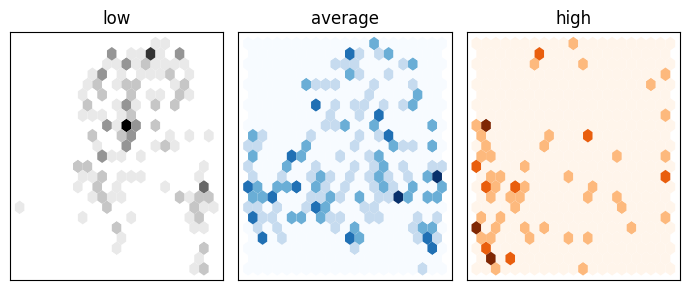

In [33]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(1, 3, figsize=(7,3))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges"]
labels = code_qual_dataset["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap,
                   gridsize=20, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]), axes[i].set_yticks([])

plt.tight_layout()
plt.show()

In [34]:
from sklearn.linear_model import LogisticRegression

# We increase `max_iter` to guarantee convergence
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
lr_clf.score(X_valid, y_valid)

0.6551724137931034

In [35]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="uniform")
dummy_clf.fit(X_train, y_train)
dummy_clf.score(X_valid, y_valid)

0.33620689655172414

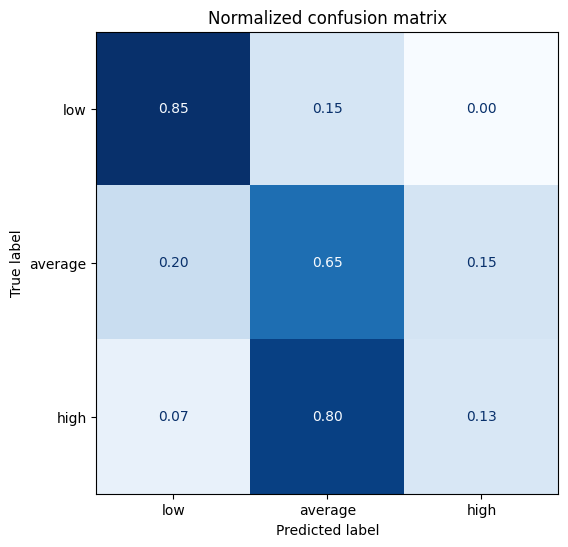

In [36]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

y_preds = lr_clf.predict(X_valid)
plot_confusion_matrix(y_preds, y_valid, labels)

In [40]:
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def evaluate(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')

    return accuracy, f1, precision, recall

print(evaluate(y_valid, y_preds))

(0.6551724137931034, 0.6427145113700712, 0.6351356693064951, 0.6551724137931034)
